# Bayesian Neural Networks with Pyro



## Bayesian Neural Networks


베이지안 신경망은 네트워크의 가중치와 편향을 고정된 값이 아닌 확률 분포로 표현하여 예측의 불확실성을 추정할 수 있는 확률적 모델입니다. 이를 통해 가중치와 편향에 대한 사전 지식을 모델에 *통합*하고 데이터를 관찰하면서 이에 대한 신념을 *업데이트*할 수 있다.

수학적으로 베이지안 신경망은 다음과 같이 표현:

입력 데이터 집합 $x$가 주어졌을 때, 우리는 해당 출력 $y$를 예측하고자 한다. 신경망은 이 관계를 함수 $f(x, \theta)$로 표현하며, 여기서 $\theta$는 네트워크의 가중치와 편향성이다. 베이지안 신경망에서는 가중치와 편향을 확률 분포로 표현하므로, $f(x, \theta)$는 가능한 출력에 대한 확률 분포가 된다.:

$$ p(y|x, \mathcal{D}) = \int p(y|x, \theta)p(\theta|\mathcal{D}) d\theta $$.

여기서 $p(y|x, \theta)$는 $x$와 $\theta$가 주어졌을 때 $y$를 관측할 확률을 나타내는 확률 함수이고, $p(\theta|\mathcal{D})$는 관측된 데이터 $\mathcal{D}$에 대한 가중치와 편향에 대한 사후후분포이다.

예측을 하기 위해 우리는 사후 예측 분포를 사용한다.:

$$ p(y^*|x^*, \mathcal{D}) = \int p(y^*|x^*, \theta)p(\theta|\mathcal{D}) d\theta $$.

여기서 $x^*$는 새로운 입력이고 $y^*$는 그에 상응하는 예측 출력이다.

(다루기 어려운) 사후 분포 $p(\theta|\mathcal{D})$를 추정하기 위해 마르코프 체인 몬테카를로(MCMC) 또는 변동 추론(VI)을 사용할 수 있다.

In [6]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Simulate data

정현파 함수에서 노이즈가 있는 데이터를 만든다.

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

x_obs = np.hstack([np.linspace(-0.2, 0.2, 500), np.linspace(0.6, 1, 500)])
noise = 0.02 * np.random.randn(x_obs.shape[0])
y_obs = x_obs + 0.3 * np.sin(2 * np.pi * (x_obs + noise)) + 0.3 * np.sin(4 * np.pi * (x_obs + noise)) + noise

x_true = np.linspace(-0.5, 1.5, 1000)
y_true = x_true + 0.3 * np.sin(2 * np.pi * x_true) + 0.3 * np.sin(4 * np.pi * x_true)

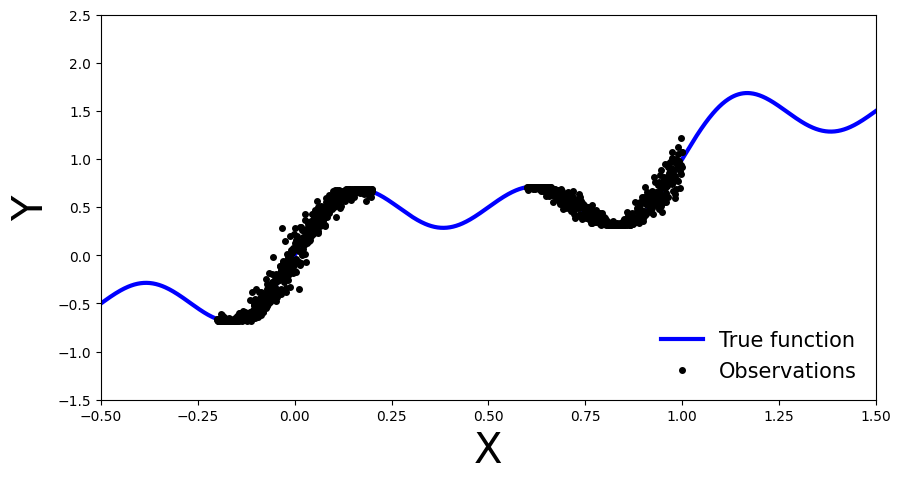

In [7]:
xlims = [-0.5, 1.5]
ylims = [-1.5, 2.5]

# Create plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x_true, y_true, 'b-', linewidth=3, label="True function")
ax.plot(x_obs, y_obs, 'ko', markersize=4, label="Observations")
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_xlabel("X", fontsize=30)
ax.set_ylabel("Y", fontsize=30)
ax.legend(loc=4, fontsize=15, frameon=False)

plt.show()

## Getting started with Pyro

이제 Pyro를 설치해 보겠습니다. 이 단계 후에 런타임을 다시 시작해야 할 수도 있다.

In [1]:
#%pip install pyro-ppl

## BNN with Gaussian Prior and Likelihood

첫 번째 베이지안 신경망은 가중치에 가우시안 사전확률과 데이터에 대한 가우시안 확률 함수를 사용한다. 이 네트워크는 하나의 숨겨진 계층을 가진 얕은 신경망이다.

구체적으로, 가중치 $\theta$에 다음과 같은 사전을 사용한다.:

$p(\theta) = \mathcal{N}(\mathbf{0}, 10\cdot\mathbb{I}),$ 여기서 $\mathbb{I}$는 행렬 행렬이다..

네트워크를 훈련하기 위해 네트워크의 예측된 출력과 실제 데이터 포인트를 비교하는 확률 함수를 정의한다.:

$p(y_i| x_i, \theta) = \mathcal{N}\big(NN_{\theta}(x_i), \sigma^2\big)$, 이전 $\sigma \sim \Gamma(1,1)$가 있다.

In [9]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn


class MyFirstBNN(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, hid_dim=5, prior_scale=10.):
        super().__init__()

        self.activation = nn.Tanh()  # or nn.ReLU()
        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)  # Input to hidden layer
        self.layer2 = PyroModule[nn.Linear](hid_dim, out_dim)  # Hidden to output layer

        # layer parameter를 random variables 임의의 변수로 설정
        self.layer1.weight = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim, in_dim]).to_event(2))
        self.layer1.bias = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim]).to_event(1))
        self.layer2.weight = PyroSample(dist.Normal(0., prior_scale).expand([out_dim, hid_dim]).to_event(2))
        self.layer2.bias = PyroSample(dist.Normal(0., prior_scale).expand([out_dim]).to_event(1))

    def forward(self, x, y=None):
        x = x.reshape(-1, 1)
        x = self.activation(self.layer1(x))
        mu = self.layer2(x).squeeze()
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))  # Infer the response noise

        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)
        return mu

## Define and run Markov chain Monte Carlo sampler

우선, MCMC를 사용하여 몬테카를로 샘플링을 통해 $p(y|x, \mathcal{D}) = \mathbb{E}_{\theta \sim p(\theta|\mathcal{D})}\big[p(y|x,\theta)\big]$의 *편향되지 않은 추정*을 계산할 수 있습다. 

구체적으로 $\mathbb{E}_{\theta \sim p(\theta|\mathcal{D})}\big[p(y|x,\theta)\big]$는 다음과 같이 근사화:
$$\mathbb{E}_{\theta \sim p(\theta|\mathcal{D})}\big[p(y|x,\theta)\big] \approx \frac{1}{N} \sum_{i=1}^{N} p(y|x,\theta_{i}),$$
여기서 $\theta_{i} \sim p(\theta_i|\mathcal{D}) \propto p(\mathcal{D}|\theta)p(\theta)$ 는 사후분포에서 추출한 샘플이다. 정규화 상수는 다루기 어렵기 때문에 정규화되지 않은 후분포에서 샘플을 추출하려면 해밀턴 몬테카를로와 같은 MCMC 방법이 필요하다.

여기서는 No-U-Turn 커널을 사용한다.

In [ ]:
from pyro.infer import MCMC, NUTS

model = MyFirstBNN().to(device)

pyro.set_rng_seed(42)

# Define Hamiltonian Monte Carlo (HMC) kernel
# NUTS = "No-U-Turn Sampler" (https://arxiv.org/abs/1111.4246), gives HMC an adaptive step size
# 해밀턴 몬테카를로(HMC) 커널 정의하기
# NUTS = "No-U-Turn 샘플러"(https://arxiv.org/abs/1111.4246), HMC에 적응형 스텝 크기 제공
nuts_kernel = NUTS(model, jit_compile=True)

# MCMC 샘플러 정의, 50개의 후행 샘플 가져오기
mcmc = MCMC(nuts_kernel, num_samples=50)

x_train = torch.from_numpy(x_obs).float()
y_train = torch.from_numpy(y_obs).float()

mcmc.run(x_train, y_train)

In [11]:
from pyro.infer import Predictive

predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())
x_test = torch.linspace(xlims[0], xlims[1], 3000)
preds = predictive(x_test)

In [12]:
def plot_predictions(preds):
    y_pred = preds['obs'].T.detach().numpy().mean(axis=1)
    y_std = preds['obs'].T.detach().numpy().std(axis=1)

    fig, ax = plt.subplots(figsize=(10, 5))
    xlims = [-0.5, 1.5]
    ylims = [-1.5, 2.5]
    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.xlabel("X", fontsize=30)
    plt.ylabel("Y", fontsize=30)

    ax.plot(x_true, y_true, 'b-', linewidth=3, label="true function")
    ax.plot(x_obs, y_obs, 'ko', markersize=4, label="observations")
    ax.plot(x_obs, y_obs, 'ko', markersize=3)
    ax.plot(x_test, y_pred, '-', linewidth=3, color="#408765", label="predictive mean")
    ax.fill_between(x_test, y_pred - 2 * y_std, y_pred + 2 * y_std, alpha=0.6, color='#86cfac', zorder=5)

    plt.legend(loc=4, fontsize=15, frameon=False)

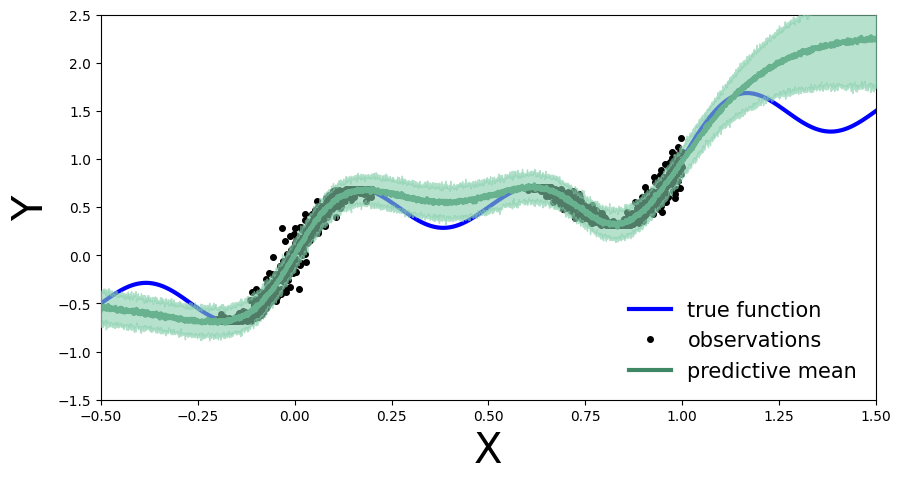

In [13]:
plot_predictions(preds)

## Exercise 1: Deep Bayesian Neural Network


비슷한 방식으로 딥 베이지안 신경망을 정의할 수 있으며, 가중치에 가우시안 전제를 사용할 수 있다:

$p(\theta) = \mathcal{N}(\mathbf{0}, 5\cdot\mathbf{I})$.

확률 함수 역시 가우스 함수이다.:

$p(y_i| x_i, \theta) = \mathcal{N}\big(NN_{\theta}(x_i), \sigma^2\big)$, 여기서 $\sigma \sim \Gamma(0.5,1)$ 이다.

- 심층 베이지안 신경망을 구현하고 MCMC를 실행하여 후방 샘플을 얻는다.
- 예측 분포를 계산하고 시각화하낟..
- 다음 네트워크 아키텍처를 사용한다.: 은닉층 레이어 수: 5, 레이어당 은닉 단위 수: 10, 활성화 함수: Tanh, 이전 스케일: 5.

In [14]:
class BNN(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, hid_dim=10, n_hid_layers=5, prior_scale=5.):
        super().__init__()

        self.activation = nn.Tanh()
        assert in_dim > 0 and out_dim > 0 and hid_dim > 0 and n_hid_layers > 0

        # Define the layer sizes and the PyroModule layer list
        # 레이어 크기와 PyroModule 레이어 목록을 정의합니다.
        self.layer_sizes = [in_dim] + n_hid_layers * [hid_dim] + [out_dim]
        layer_list = [PyroModule[nn.Linear](self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in
                      range(1, len(self.layer_sizes))]
        self.layers = PyroModule[torch.nn.ModuleList](layer_list)

        for layer_idx, layer in enumerate(self.layers):
            layer.weight = PyroSample(dist.Normal(0., prior_scale * np.sqrt(2 / self.layer_sizes[layer_idx])).expand(
                [self.layer_sizes[layer_idx + 1], self.layer_sizes[layer_idx]]).to_event(2))
            layer.bias = PyroSample(dist.Normal(0., prior_scale).expand([self.layer_sizes[layer_idx + 1]]).to_event(1))

    def forward(self, x, y=None):
        x = x.reshape(-1, 1)
        x = self.activation(self.layers[0](x))  # input --> hidden
        for layer in self.layers[1:-1]:
            x = self.activation(layer(x))  # hidden --> hidden
        mu = self.layers[-1](x).squeeze()  # hidden --> output
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))  # infer the response noise

        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)
        return mu

### Train the deep BNN with MCMC...

In [15]:
model = BNN(hid_dim=10, n_hid_layers=5, prior_scale=5.).to(device)

# MCMC 샘플러 정의
nuts_kernel = NUTS(model, jit_compile=False)
mcmc = MCMC(nuts_kernel, num_samples=50)
mcmc.run(x_train, y_train)

Sample: 100%|██████████| 100/100 [12:47,  7.67s/it, step size=8.22e-04, acc. prob=0.796]


Compute predictive distribution...

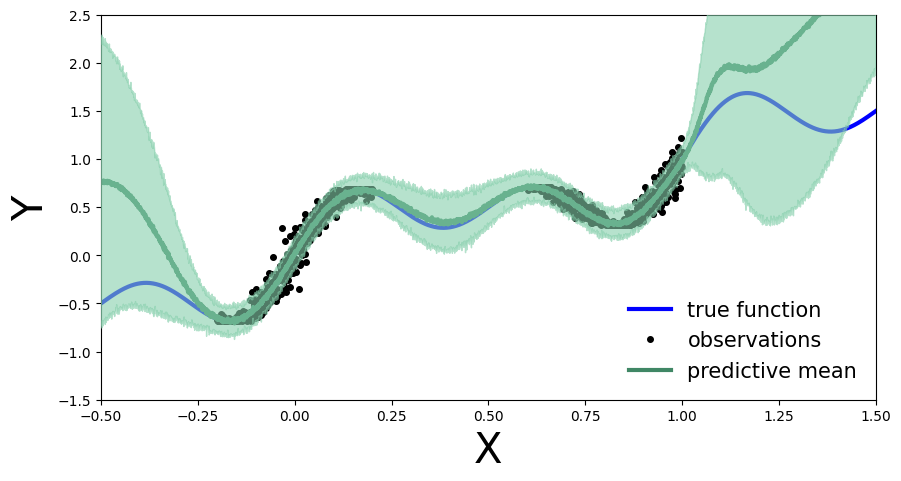

In [16]:
predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())
preds = predictive(x_test)
plot_predictions(preds)

## Train BNNs with mean-field variational inference

이제 variational inference로 넘어가면, 정규화된 후방 확률 밀도 $p(\theta|\mathcal{D})$는 다루기 어렵기 때문에, 확률 밀도 계열 $\mathcal{Q}$에서 다루기 쉬운 매개변수화된 밀도 $q_{\phi}(\theta)$로 근사화한다. 

변형 파라미터는 $\phi$로 표시되며, Pyro에서는 변형 밀도를 "가이드"라고 부른다. 목표는 변동 파라미터에 대한 KL 발산 $$KL\big(q_{\phi}(\theta)||p(\theta|\mathcal{D})\big)$$를 최소화하여 후방에 가장 근접하는 변동 확률 밀도를 찾는 것이다.
그러나 후방 밀도가 다루기 어렵다고 가정하기 때문에 KL 발산을 직접 최소화하는 것은 추적할 수 없다. 이를 해결하기 위해 베이즈 정리를 사용하여 다음을 구한다.

$$
\log p(\mathcal{D}|\theta) = KL\big(q_{\phi}(\theta)||p(\theta|\mathcal{D})\big) + ELBO(q_{\phi}(\theta)),
$$

여기서 $ELBO(q_{\phi}(\theta))$ 는 *증거 하한*이며, 다음과 같이 주어진다.

$$
ELBO(q_{\phi}(\theta)) = \mathbb{E}_{\theta \sim q_{\phi}(\theta)}\big[\log p(y|x,\theta) \big] - KL\big(q_{\phi}(\theta) || p(\theta) \big).
$$

ELBO를 최대화함으로써 간접적으로 변동 확률 밀도와 사후 밀도 사이의 KL 차이를 최소화할 수 있다.

Set up for stochastic variational inference with the variational density $q_{\phi}(\theta)$ by using a normal probability density with a diagonal covariance matrix:

In [17]:
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal
from tqdm.auto import trange
pyro.clear_param_store()

model = BNN(hid_dim=10, n_hid_layers=5, prior_scale=5.).to(device)
mean_field_guide = AutoDiagonalNormal(model)
optimizer = pyro.optim.Adam({"lr": 0.01})

svi = SVI(model, mean_field_guide, optimizer, loss=Trace_ELBO())
pyro.clear_param_store()

num_epochs = 25000
progress_bar = trange(num_epochs)

for epoch in progress_bar:
    loss = svi.step(x_train, y_train)
    progress_bar.set_postfix(loss=f"{loss / x_train.shape[0]:.3f}")

  0%|          | 0/25000 [00:00<?, ?it/s]

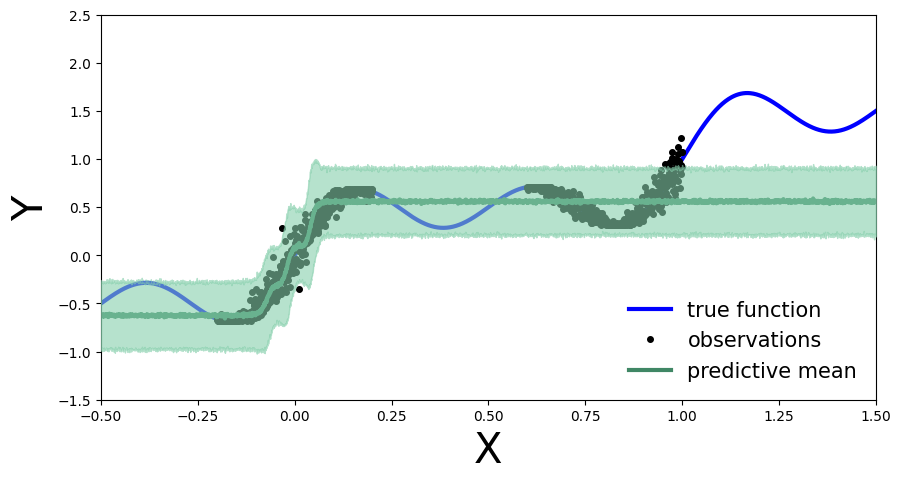

In [18]:
predictive = Predictive(model, guide=mean_field_guide, num_samples=500)
preds = predictive(x_test)
plot_predictions(preds)

## Exercise 2: Bayesian updating with variational inference

관측값 $\mathcal{D}$를 사용하여 변동 추론을 수행한 후 $\mathcal{D}'$로 표시되는 새로운 데이터 포인트를 얻으면 어떻게 될까?

In [19]:
# 새로운 데이터 생성
x_new = np.linspace(0.2, 0.6, 100)
noise = 0.02 * np.random.randn(x_new.shape[0])
y_new = x_new + 0.3 * np.sin(2 * np.pi * (x_new + noise)) + 0.3 * np.sin(4 * np.pi * (x_new + noise)) + noise

# true function 생성
x_true = np.linspace(-0.5, 1.5, 1000)
y_true = x_true + 0.3 * np.sin(2 * np.pi * x_true) + 0.3 * np.sin(4 * np.pi * x_true)

/tmp/ipykernel_2807748/1208744758.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_new, y_new, 'ko', markersize=4, label="New observations", c="r")


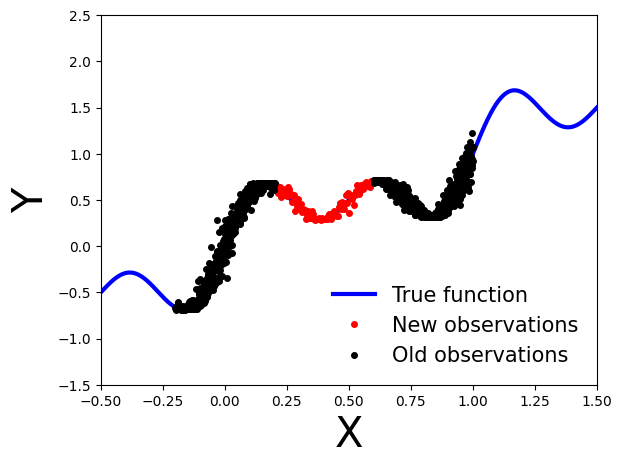

In [19]:
plt.xlim(xlims)
plt.ylim(ylims)
plt.xlabel("X", fontsize=30)
plt.ylabel("Y", fontsize=30)

plt.plot(x_true, y_true, 'b-', linewidth=3, label="True function")
plt.plot(x_new, y_new, 'ko', markersize=4, label="New observations", c="r")
plt.plot(x_obs, y_obs, 'ko', markersize=4, label="Old observations")
plt.legend(loc=4, fontsize=15, frameon=False)
plt.show()

## 베이지안 업데이트

새로운 관측값을 사용할 수 있을 때 변동 추론을 사용하여 모델에 대한 베이지안 업데이트를 수행하려면 어떻게 해야 하는가?

이전에 계산된 사후 확률 밀도를 새로운 선행으로 사용하고 새로운 관측치로 후행을 업데이트할 수 있다. 구체적으로 업데이트된 사후 확률 밀도는 다음과 같습니다:

$$
p(\theta|\mathcal{D}') = \frac{p(\mathcal{D}'|\theta)q_{\phi}(\theta)}{\int p(\mathcal{D}'|\theta)q_{\phi}(\theta)}{\int p(\mathcal{D}'|\theta)}
$$

새로운 선행으로 사용된 변동 밀도가 이전 관측치 $\mathcal{D}$에 필요한 정보를 전달한다는 사실에 의존하여 새로운 관측치 $\mathcal{D}'$만을 사용하여 모델을 업데이트하고자 한다는 점에 유의한다.


### Pyro에서 구현

'guide'에서 변동 파라미터(평균 및 표준 편차)를 추출하고 이를 사용하여 변동 추론에 사용된 원래 모델과 유사한 새 모델에서 사전을 초기화할 수 있다.

Gaussian `guide`에서 변형 파라미터(평균 및 표준 편차)를 다음과 같이 추출하면:

```python
mu = guide.get_posterior().mean
sigma = guide.get_posterior().stddev
```





### Exercise 2.1 Learn a model on the old observations

먼저, 이전과 마찬가지로 가우스 선행 $\mathcal{N}(\mathbf{0}, 10\cdot \mathbb{I})$를 사용하여 모델을 정의한다.

- `AutoDiagonalNormal()`을 가이드 삼아 변형 추론을 사용하여 이전 관측치 $\mathcal{D}$에 대해 모델 `MyFirstBNN`을 훈련한다.

In [20]:
from pyro.optim import Adam
pyro.set_rng_seed(42)
pyro.clear_param_store()

model = MyFirstBNN().to(device)
guide = AutoDiagonalNormal(model)
optim = Adam({"lr": 0.03})
svi = pyro.infer.SVI(model, guide, optim, loss=Trace_ELBO())

num_iterations = 10000
progress_bar = trange(num_iterations)

for j in progress_bar:
    loss = svi.step(x_train, y_train)
    progress_bar.set_description("[iteration %04d] loss: %.4f" % (j + 1, loss / len(x_train)))

  0%|          | 0/10000 [00:00<?, ?it/s]

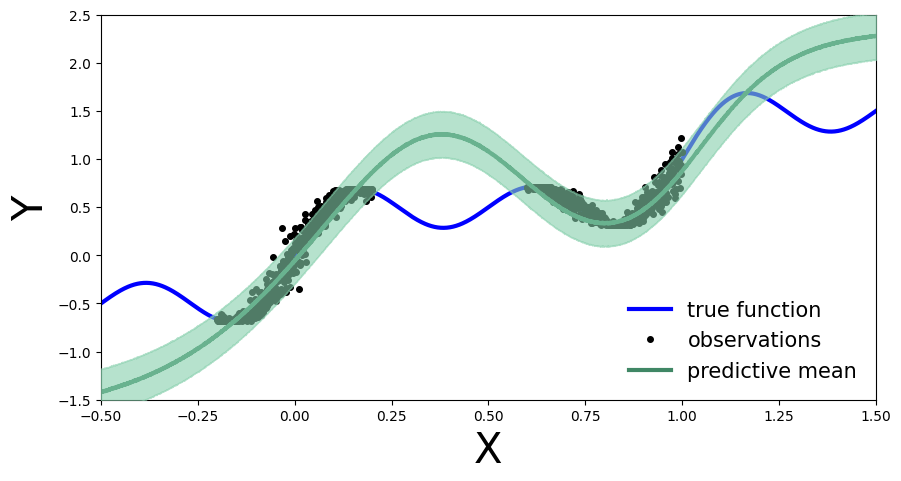

In [21]:
predictive = Predictive(model, guide=guide, num_samples=5000)
preds = predictive(x_test)
plot_predictions(preds)

다음으로, 가이드에서 변동 매개변수(평균 및 표준편차)를 추출하고 이를 사용하여 변동 추론에 사용된 원래 모델과 유사한 새 모델에서 이전 모델을 초기화한다.

In [22]:
# Extract variational parameters from guide
# 가이드에서 변형 매개 변수 추출
mu = guide.get_posterior().mean.detach()
stddev = guide.get_posterior().stddev.detach()

In [23]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDiagonalNormal.loc Parameter containing:
tensor([ 4.4191,  2.0755,  2.5222,  2.9757, -2.8465, -4.5504, -0.6823,  8.6810,
         8.4490,  1.4790,  1.2583,  5.1179,  0.9285, -1.8939,  4.3386,  1.2919,
        -1.0739], requires_grad=True)
AutoDiagonalNormal.scale tensor([1.4527e-02, 2.4027e-03, 2.1620e+00, 1.6080e+00, 4.6767e-03, 1.4399e-02,
        1.4626e-03, 1.5920e+00, 8.8793e-01, 2.9016e-03, 6.1736e-03, 9.5348e-03,
        6.3799e-03, 5.4559e-03, 7.9139e-03, 5.9700e-03, 4.8264e-02],
       grad_fn=<SoftplusBackward0>)


### Exercise 2.2 Initialize a second model with the variational parameters

`MyFirstBNN(PyroModule)`과 유사한 새 모델을 정의하고, 가변 매개변수를 사용하여 이전 모델을 초기화하는 데 사용한다.

In [24]:
class UpdatedBNN(PyroModule):
    def __init__(self, mu, stddev, in_dim=1, out_dim=1, hid_dim=5):
        super().__init__()
        self.mu = mu
        self.stddev = stddev

        self.activation = nn.Tanh()
        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)
        self.layer2 = PyroModule[nn.Linear](hid_dim, out_dim)

        self.layer1.weight = PyroSample(dist.Normal(self.mu[0:5].unsqueeze(1), self.stddev[0:5].unsqueeze(1)).to_event(2))
        self.layer1.bias = PyroSample(dist.Normal(self.mu[5:10], self.stddev[5:10]).to_event(1))
        self.layer2.weight = PyroSample(dist.Normal(self.mu[10:15].unsqueeze(0), self.stddev[10:15].unsqueeze(0)).to_event(2))
        self.layer2.bias = PyroSample(dist.Normal(self.mu[15:16], self.stddev[15:16]).to_event(1))
        # 17th parameter is parameter sigma from the Gamma distribution
        # 17번째 파라미터는 감마 분포의 파라미터 시그마입니다.

    def forward(self, x, y=None):
        x = x.reshape(-1, 1)
        x = self.activation(self.layer1(x))
        mu = self.layer2(x).squeeze()
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))

        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)
        return mu

### Exercise 2.3 Perform variational inference on the new model

그런 다음 새 관측값을 사용하여 이 새 모델에 대한 변동 추론을 수행하고 예측 분포를 시각화한다.

In [25]:
x_train_new = torch.from_numpy(x_new).float()
y_train_new = torch.from_numpy(y_new).float()

pyro.clear_param_store()
new_model = UpdatedBNN(mu, stddev).to(device)
new_guide = AutoDiagonalNormal(new_model)
optim = Adam({"lr": 0.01})
svi = pyro.infer.SVI(new_model, new_guide, optim, loss=Trace_ELBO())

num_iterations = 1000
progress_bar = trange(num_iterations)

for j in progress_bar:
    loss = svi.step(x_train_new, y_train_new)
    progress_bar.set_description("[iteration %04d] loss: %.4f" % (j + 1, loss / len(x_train)))


  0%|          | 0/1000 [00:00<?, ?it/s]

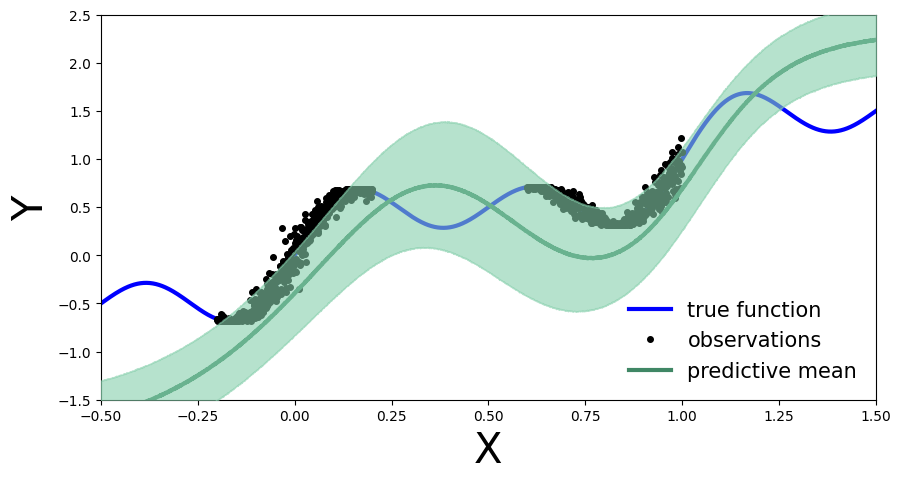

In [26]:
predictive = Predictive(new_model, guide=new_guide, num_samples=5000)
preds = predictive(x_test)
plot_predictions(preds)